<div align="center">
<h3> CS 178: Machine Learning & Data Mining </h3>
<h1> Discussion, Week 4 </h1>
</div>

Let's start by importing some packages. We'll point out which of these imports we are using throughout the discussion, but it's handy to have them all in one place at the top of your notebook. This way, you can reload the imports without having to re-run everything else.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay

seed=1234
np.random.seed(seed)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 50

### Logistic Regression on MNIST

First we will load in the MNIST data. This is a dataset of handwritten numerical digits (0, 1, 2, ..., 9) represented as 28x28 pixel images. The features will be the individual pixel values and the class labels are the corresponding digit that they are supposed to represent.

In [4]:
# Load the features and labels for the MNIST dataset
# This might take a minute to download the images.
mnist_X, mnist_y = fetch_openml('mnist_784', as_frame=False, return_X_y=True, parser='auto')

# print(mnist_y[:10])

# Convert labels to integer data type
mnist_y = mnist_y.astype(int)

We will be focusing on just two of the digits today for simplification. Namely, we want to predict whether a given image is a '8' or a '0'.

In [6]:
wanted_digits = np.isin(mnist_y, [8, 0])
print(wanted_digits)
mnist_X_subset, mnist_y_subset = mnist_X[wanted_digits, :], mnist_y[wanted_digits]
mnist_X_subset.shape, mnist_y_subset.shape, np.unique(mnist_y_subset)

[False  True False ... False False False]


((13728, 784), (13728,), array([0, 8]))

We will split this dataset into a train and test split, with 75% of the original data belonging to the training portion.

In [7]:
mnist_X_tr, mnist_X_te, mnist_y_tr, mnist_y_te = train_test_split(
    mnist_X_subset, mnist_y_subset, test_size=0.25, random_state=seed, shuffle=True
)

#### Plotting Images

The data comes preprocessed for us into a vector format for the features, so we will need to reshape it first to resemble a grid of pixels (i.e., an image). We can see the actual values by printing the array directly, or we can more naturally visualize it using the `.imshow()` method.

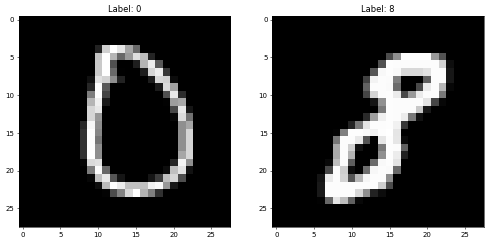

In [10]:
figure, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, ax in enumerate(axes):
    img = mnist_X_tr[i].reshape(28, 28)
    ax.imshow(img, cmap="gray")
    label = mnist_y_tr[i]
    ax.set_title(f'Label: {label}')

In [ ]:
np.unique(mnist_X_tr)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

We see that the individual pixel values can take on integer values between 0 (black) and 255 (white).

#### Prepocessing Images

We want to use logistic regression to predict whether a digit is a '8' or a '0'; however, logistic regression typically is more stable when using normalized inputs. Let's look at what happens to the data when we perform mean/standard deviation scaling vs. min/max scaling.

In [12]:
mnist_X_tr.shape

(10296, 784)

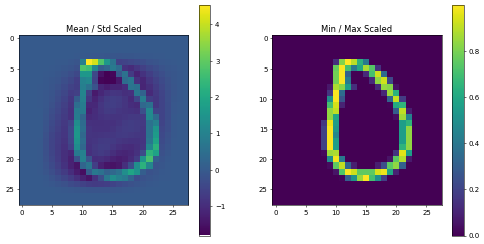

In [13]:
# Only compute scaling statistics on the training data!
X_mean, X_std = mnist_X_tr.mean(axis=0), mnist_X_tr.std(axis=0)
X_min, X_max = mnist_X_tr.min(axis=0), mnist_X_tr.max(axis=0)

figure, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot mean/standard deviation scaled image
ax = axes[0]
img = ((mnist_X_tr[0] - X_mean) / (X_std + 1e-4)).reshape(28, 28)  # Add very small value to avoid dividing by 0
m = ax.imshow(img, cmap="viridis")
figure.colorbar(m, ax=ax)
ax.set_title(f'Mean / Std Scaled')

# Plot min/max scaled image
ax = axes[1]
img = ((mnist_X_tr[0] - X_min) / (X_max - X_min + 1e-4)).reshape(28, 28)   # Add very small value to avoid dividing by 0
m = ax.imshow(img, cmap="viridis")
figure.colorbar(m, ax=ax)
ax.set_title(f'Min / Max Scaled');

We will be trying both of these out in our model selection phase!

In [14]:
# min-max scaling
mm_X_tr = (mnist_X_tr - X_min) / (X_max - X_min + 1e-4)
mm_X_te = (mnist_X_te - X_min) / (X_max - X_min + 1e-4)  # We need to transform the test data as well!

# mean-std scaling
ms_X_tr = (mnist_X_tr - X_mean) / (X_std + 1e-4)
ms_X_te = (mnist_X_te - X_mean) / (X_std + 1e-4)  # We need to transform the test data as well!

The last preprocessing step is to get the target values. We will have $y=1$ when the digit is a '0' and $y=0$ when the digit is an '8'. This means that the output probability of the logistic regression model will correspond to the probability that the given image is a '0', and 1 minus that probability will correspond to the probability that the given image is an '8'.

In [15]:
is_zero_y_tr, is_zero_y_te = (mnist_y_tr==0).astype(float), (mnist_y_te==0).astype(float)

We will now look at logistic regression models with $L_1$ and $L_2$ penalties, each having a regularization parameter of $C=[0.02, 0.1, 1, 10, 50]$. We will try each combination of these settings with the different data preprocessing and evaluate them on the test data.

In [16]:
def fit_model(train_X, train_y, test_X, test_y, penalty, c):
    model = LogisticRegression(penalty=penalty, C=c, solver="liblinear")# if penalty=="l1" else "lbfgs")
    model.fit(train_X, train_y)
    pred_y = model.predict(test_X)
    acc = accuracy_score(test_y, pred_y)
    recall = recall_score(test_y, pred_y)
    prec = precision_score(test_y, pred_y)
    return model, acc, recall, prec

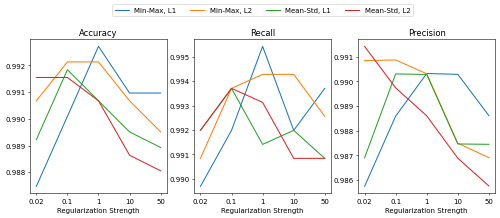

In [17]:
# Expected to take ~30s to run

figure, axes = plt.subplots(1, 3, figsize=(12, 4))
cs = [0.02, 0.1, 1, 10, 50]
x_axis_vals = list(range(len(cs)))

for data_preprocess_type, train_X, test_X in [("Min-Max", mm_X_tr, mm_X_te), ("Mean-Std", ms_X_tr, ms_X_te)]:
    for penalty_type in ('l1', 'l2'):
        accs, recalls, precs = [], [], []
        for c in cs:
            _, acc, recall, prec = fit_model(train_X, is_zero_y_tr, test_X, is_zero_y_te, penalty_type, c)
            accs.append(acc)
            recalls.append(recall)
            precs.append(prec)

        for metric, ax in zip([accs, recalls, precs], axes):
            ax.plot(x_axis_vals, metric, label="{}, {}".format(data_preprocess_type, penalty_type.capitalize()))

for metric_name, ax in zip(["Accuracy", "Recall", "Precision"], axes):
    ax.set_title(metric_name)
    ax.set_xticks(x_axis_vals)
    ax.set_xticklabels(cs)
    ax.set_xlabel("Regularization Strength")

axes[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.25), ncol=4);


It seems that using the Min-Max normalization scheme with a $L_1$ penalty strength of $c=1$ yielded the highest accuracy and recall. The highest precision was the Mean-Std normalized data with a $L_2$ penalty strength of $c=0.02$. Let's visualize both of their learned coefficients.

In [18]:
model_1, _, _, _ = fit_model(mm_X_tr, is_zero_y_tr, mm_X_te, is_zero_y_te, 'l1', 1.0)
model_2, _, _, _ = fit_model(ms_X_tr, is_zero_y_tr, ms_X_te, is_zero_y_te, 'l2', 0.02)

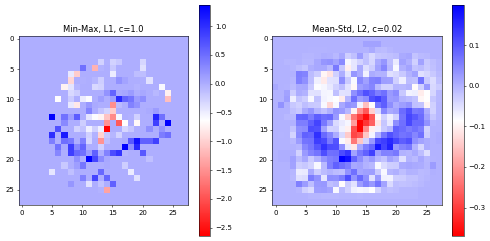

In [19]:
figure, axes = plt.subplots(1, 2, figsize=(12, 6))

m = axes[0].imshow(model_1.coef_.reshape(28, 28), cmap="bwr_r")
figure.colorbar(m, ax=axes[0])
axes[0].set_title(f'Min-Max, L1, c=1.0')

m = axes[1].imshow(model_2.coef_.reshape(28, 28), cmap="bwr_r")
figure.colorbar(m, ax=axes[1])
axes[1].set_title(f'Mean-Std, L2, c=0.02');

When an input image's pixel is bright, then the corresponding location in these graphs indicate whether this tells the model that the image is more likely to be a '0' digit (blue) or an '8' digit (red). For both, we can see that if some pixel value in the very middle of an image is white, then this tends to correspond highly to '8' digit images, which makes sense. Note the sparsity of non-zero coefficient values on the left-hand plot. This is due to the $L_1$ penalty preferring few non-zero coefficients.

### Decision Boundaries

In [20]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000, n_features=2, centers=2, random_state=1)

Xtr, Xte, ytr, yte = train_test_split(X, y)

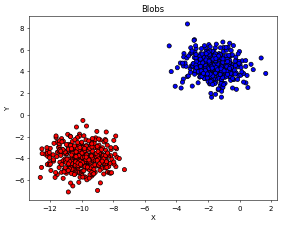

In [21]:
fig, ax = plt.subplots()

ax.scatter(Xtr[:,0], Xtr[:,1], c=ytr, edgecolor='k', cmap='bwr');
ax.set_title("Blobs");
ax.set_xlabel("X");
ax.set_ylabel("Y");

In [22]:
# with bias, no penalty
lr = LogisticRegression(fit_intercept=True, penalty=None)

# fit to training data
lr.fit(Xtr, ytr);

# score mean train accuracy
print("Train accuracy:", lr.score(Xtr, ytr))
print("Test accuracy:", lr.score(Xte, yte))

Train accuracy: 1.0
Test accuracy: 1.0


In [46]:
def plot_decision_boundary(model, Xtr, ytr):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    ax = axes[0]
    DecisionBoundaryDisplay.from_estimator(
        model, Xtr, cmap="bwr", ax=ax, response_method="predict", alpha=0.6,
        plot_method="pcolormesh", shading="auto", xlabel="X", ylabel="Y", eps=2,
    )

    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr, edgecolors='white', cmap='bwr')
    ax.set_title("Hard Decision Boundary")

    ax = axes[1]
    DecisionBoundaryDisplay.from_estimator(
        model, Xtr, cmap="bwr", ax=ax, response_method="predict_proba", alpha=0.6,
        plot_method="pcolormesh", shading="auto", xlabel="X", ylabel="Y", eps=0.5,
    )

    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr, edgecolors='white', cmap='bwr')
    ax.set_title("Soft Decision Boundary (w/ probs)")

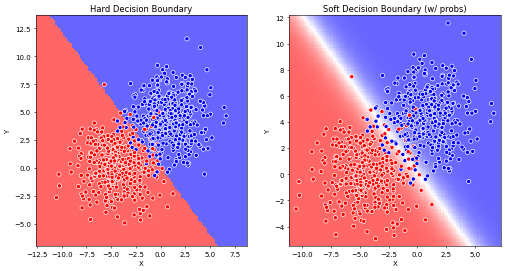

In [47]:
plot_decision_boundary(lr, Xtr, ytr)

Train accuracy: 0.9506666666666667
Test accuracy: 0.96


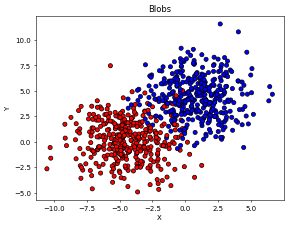

In [38]:
X, y = make_blobs(n_samples=1000, n_features=2, centers=2, cluster_std=2, random_state=3)

Xtr, Xte, ytr, yte = train_test_split(X, y)

fig, ax = plt.subplots()

ax.scatter(Xtr[:,0], Xtr[:,1], c=ytr, edgecolor='k', cmap='bwr');
ax.set_title("Blobs");
ax.set_xlabel("X");
ax.set_ylabel("Y");

# with bias, no penalty
lr = LogisticRegression(fit_intercept=True, penalty=None)

# fit to training data
lr.fit(Xtr, ytr);

# score mean train accuracy
print("Train accuracy:", lr.score(Xtr, ytr))
print("Test accuracy:", lr.score(Xte, yte))

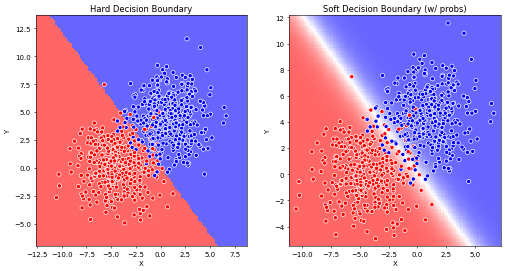

In [39]:
plot_decision_boundary(lr, Xtr, ytr)

Train accuracy: 0.7173333333333334
Test accuracy: 0.74


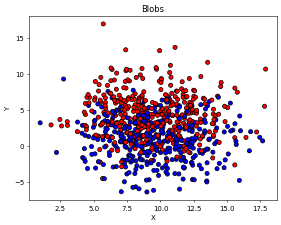

In [ ]:
X, y = make_blobs(n_samples=1000, n_features=2, centers=2, cluster_std=3, random_state=4)

Xtr, Xte, ytr, yte = train_test_split(X, y)

fig, ax = plt.subplots()

ax.scatter(Xtr[:,0], Xtr[:,1], c=ytr, edgecolor='k', cmap='bwr');
ax.set_title("Blobs");
ax.set_xlabel("X");
ax.set_ylabel("Y");

# with bias, no penalty
lr = LogisticRegression(fit_intercept=True, penalty=None)

# fit to training data
lr.fit(Xtr, ytr);

# score mean train accuracy
print("Train accuracy:", lr.score(Xtr, ytr))
print("Test accuracy:", lr.score(Xte, yte))

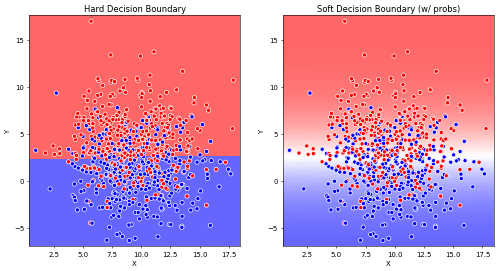

In [ ]:
plot_decision_boundary(lr, Xtr, ytr)

For any of these models, we can extract the learned coefficients easily:

In [ ]:
lr.coef_, lr.intercept_

(array([[-0.00313118,  0.38433592]]), array([-0.92028053]))